In [1]:
from contextlib import contextmanager

from sympy import *
from sympy.abc import n, i, N, x, lamda, phi, z, m, j, r

init_printing()

In [2]:
lamda = symbols('\lambda')#, real=True)
eq = Eq(det(Matrix([[1-lamda, 0, 0],
                    [-7, 1-lamda, -1],
                    [4,0,3-lamda]])),0)
eq

In [3]:
factor(eq)

In [4]:
roots(eq, lamda,)

In [39]:
@contextmanager
def lift_to_indexed(*syms):
    yield map(IndexedBase, map(latex, syms))
    
@contextmanager
def lift_to_Lambda(eq, return_eq=False):
    yield Lambda(eq.lhs.args, eq if return_eq else eq.rhs)

In [44]:
indexed_phi = IndexedBase(r'\phi')

def make_Phi_poly(z, deg, i, j, indexed=indexed_phi):
    k = symbols('k')
    terms = Sum(indexed[i, j, deg-k] * z**k, (k, 0, deg)).doit()
    return Eq(Function(r'\Phi')(z, i, j), terms)


In [55]:
m = 2 # degree of \Xi minimal polynomial

In [59]:
Phi_poly = make_Phi_poly(z, deg=m-1, i=symbols('i'), j=symbols('j'))
Phi_poly

In [60]:
with lift_to_Lambda(Phi_poly) as Phi:
    pass
Phi

In [61]:
Phi(z, 3, j)

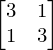

In [62]:
m = Matrix([
        [3, 1],
        [1, 3]
    ])
m

In [64]:
m.eigenvals()

In [65]:
lamda_indexed = IndexedBase(r'\lambda')
mul_indexed = IndexedBase(r'm')

def eigen_data(matrix):
    eigenvals = {}
    multiplicities = {}
    data = {}
    for i, (eigen_value, multiplicity) in enumerate(matrix.eigenvals().items(), start=1):
        eigenvals[lamda_indexed[i]] = eigen_value
        multiplicities[mul_indexed[i]] = multiplicity
        data[i] = lamda_indexed[i], mul_indexed[i]
    return data, eigenvals, multiplicities

In [67]:
eigen_data(m)

In [94]:
def define_Phi_poly(Phi_poly, i, j, eigendata):
    
    data, eigenvals, multiplicities = eigendata
    
    lhs = Function(r'\Phi_{{ {}, {} }}'.format(i, j))(z)
    
    with lift_to_Lambda(Phi_poly) as Phi:
        p = Eq(lhs, Phi(z, i, j))
        lamda_i, m_i = data[i]
        derivatives = [(r, Eq(Function('\delta')(z), p.rhs.diff(z, r-1))) for r in range(1, multiplicities[m_i]+1)]
        res = []
        for l, (lamda, mul) in data.items():
            for r, der in derivatives:
                with lift_to_Lambda(der) as der_fn:
                    eq = Eq(der_fn(eigenvals[lamda]), KroneckerDelta(l, i)*KroneckerDelta(r, j))
                    res.append(eq)
                    
        sols = solve(res).pop()
        
        rhs = p.rhs.subs(sols, simultaneous=True).expand()
        return p, Eq(lhs, rhs) , derivatives, res, sols
        

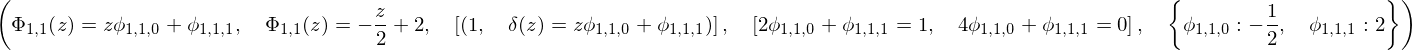

In [95]:
res = define_Phi_poly(Phi_poly, 1,1,eigen_data(m))
res

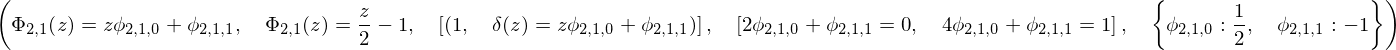

In [96]:
res = define_Phi_poly(Phi_poly, 2,1,eigen_data(m))
res

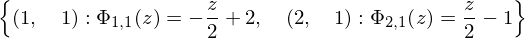

In [114]:
component_polynomials = {}

data, eigenvals, multiplicities = eigendata = eigen_data(m)
for i, (lamda, mul) in data.items():
    multiplicity = multiplicities[mul]
    for j in range(1, multiplicity+1):
        component_poly = define_Phi_poly(Phi_poly, i, j, eigendata)
        component_polynomials[i, j] = component_poly[1]

component_polynomials

In [115]:
def g_poly(f_eq, eigendata, Phi_polys):
    
    data, eigenvals, multiplicities = eigendata
    g = Integer(0)
    
    for i, (lamda, mul) in data.items():
        for j in range(1, multiplicities[mul]+1):
            with lift_to_Lambda(f_eq) as f_fn:
                der = Eq(Function(r'\delta')(z), f_fn(z).diff(z, j-1))
                with lift_to_Lambda(der) as der_fn, lift_to_Lambda(Phi_polys[i, j]) as Phi:
                    g += der_fn(lamda)*Phi(z)
    
    return Eq(Function('g')(z), g.expand())

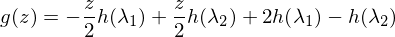

In [122]:
g = g_poly(Eq(Function('f')(z), Function('h')(z)), eigendata, component_polynomials)
g

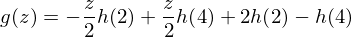

In [135]:
g = g.subs(eigenvals)
g

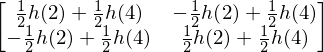

In [136]:
gpp = poly(g.rhs, z)
Z = zeros(m.rows)
for d in range(gpp.degree()+1):
    coeff = g.rhs.coeff(z, d)
    Z += coeff*m**d
Z

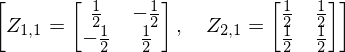

In [120]:
lifted_matrix_polynomials = []
indexed_Z = IndexedBase('Z')
for (i, j), cp in component_polynomials.items():
    cpp = poly(cp.rhs, z)
    Z = zeros(m.rows)
    for d in range(cpp.degree()+1):
        coeff = cp.rhs.coeff(z, d)
        Z += coeff*m**d
    lifted_matrix_polynomials.append(Eq(indexed_Z[i,j], Z, evaluate=False))
    
lifted_matrix_polynomials

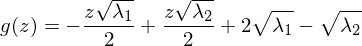

In [150]:
g = g_poly(Eq(Function('f')(z), sqrt(z)), eigendata, component_polynomials)
g

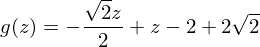

In [151]:
g = g.subs(eigenvals)
g

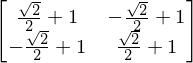

In [152]:
gpp = poly(g.rhs, z)
Z = zeros(m.rows)
for d in range(gpp.degree()+1):
    coeff = g.rhs.coeff(z, d)
    Z += coeff*m**d
Z.applyfunc(lambda c: c.simplify())

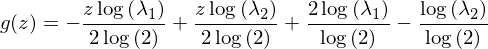

In [142]:
g = g_poly(Eq(Function('f')(z), log(z, 2)), eigendata, component_polynomials)
g

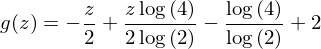

In [143]:
g = g.subs(eigenvals)
g

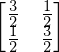

In [148]:
gpp = poly(g.rhs, z)
Z = zeros(m.rows)
for d in range(gpp.degree()+1):
    coeff = g.rhs.coeff(z, d)
    Z += coeff*m**d
Z.applyfunc(lambda c: c.simplify())

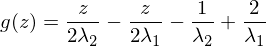

In [153]:
g = g_poly(Eq(Function('f')(z), 1/z), eigendata, component_polynomials)
g

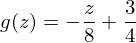

In [154]:
g = g.subs(eigenvals)
g

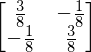

In [155]:
gpp = poly(g.rhs, z)
Z = zeros(m.rows)
for d in range(gpp.degree()+1):
    coeff = g.rhs.coeff(z, d)
    Z += coeff*m**d
Z.applyfunc(lambda c: c.simplify())

---

In [119]:
p = Function('p')
y, c, z = IndexedBase('y'),IndexedBase('c'), IndexedBase('z')

In [120]:
fibonacci_poly = Eq(p(z), z**2 -z -1)
fibonacci_poly

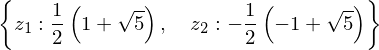

In [121]:
zs = solve(fibonacci_poly.rhs, [z])
zs ={z[i]:v for i, v in enumerate(map(factor, sorted(zs, reverse=True)), start=1)}
zs

In [122]:
solution = Eq(y[n], c[1]*z[1]**n + c[2]*z[2]**n)
solution

In [129]:
initial_conditions = {0:0, 1:1}
system = [solution.subs({n:k}).subs({y[k]:v}) for k, v in initial_conditions.items()]
system

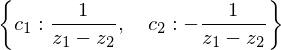

In [130]:
instantiated_sols = solve(system, [c[1],c[2]])
instantiated_sols

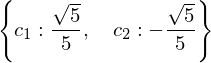

In [131]:
coeffs = {k: v.subs({z[1]:z1, z[2]:z2}).factor() for k,v in instantiated_sols.items()}
coeffs

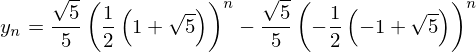

In [132]:
complete_sol = solution.subs(coeffs).subs(zs)
complete_sol

In [133]:
[complete_sol.subs(n,i).factor() for i in range(15)]